## Import Libraries

### Impor library untuk manipulasi data, visualisasi, ekstraksi fitur teks, dan modeling rekomendasi.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import shutil
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
!pip install scikit-surprise

### Menghapus versi numpy yang ada dan menginstal ulang versi 1.26.4 untuk memastikan kompatibilitas dengan library lain.

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.26.4

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


### Mengimpor modul dari library Surprise untuk membangun model collaborative filtering, termasuk SVD dan fungsi evaluasi.

In [ ]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

## Data Loading

### Mengunduh dataset buku dari Kaggle menggunakan `kagglehub`.

In [ ]:
source_path = kagglehub.dataset_download("arashnic/book-recommendation-dataset")

### Memindahkan dataset yang sudah diunduh ke folder `/content` agar mudah diakses.

In [ ]:
destination_path = '/content/book-recommendation-dataset'

if not os.path.exists(destination_path):
    os.makedirs(destination_path)

for item in os.listdir(source_path):
    s = os.path.join(source_path, item)
    d = os.path.join(destination_path, item)
    if os.path.isdir(s):
        shutil.copytree(s, d)
    else:
        shutil.copy2(s, d)

print(f"Dataset copied to: {destination_path}")

Dataset copied to: /content/book-recommendation-dataset


## Data Understanding

#### Memuat file CSV buku ke DataFrame dan menampilkan 5 baris pertama untuk melihat struktur data.

In [ ]:
books = pd.read_csv('/content/book-recommendation-dataset/Books.csv', low_memory=False)
display(books.head())

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Insight: Dataset berisi informasi dasar buku seperti ISBN, Judul Buku (Book-Title), Penulis (Book-Author), Tahun Terbit (Year-Of-Publication), dan Penerbit (Publisher). Ada juga beberapa kolom yang berisi URL gambar buku dengan ukuran kecil, sedang, dan besar (Image-URL-S, Image-URL-M, Image-URL-L) yang dapat digunakan untuk tampilan visual.

#### Memuat file CSV berisi data rating pengguna terhadap buku dan menampilkan 5 baris pertama untuk melihat struktur data.

In [ ]:
ratings = pd.read_csv('/content/book-recommendation-dataset/Ratings.csv')
display(ratings.head())

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Insight: Output tersebut menunjukkan data rating buku oleh pengguna, di mana setiap baris merepresentasikan sebuah interaksi antara pengguna (User-ID) dan buku (ISBN) dengan skor rating (Book-Rating) yang diberikan. Terlihat ada nilai rating nol, yang kemungkinan menunjukkan ketidaktertarikan atau interaksi minimal.

#### Memuat file CSV berisi data pengguna dan menampilkan 5 baris pertama untuk melihat struktur data pengguna.

In [ ]:
users = pd.read_csv('/content/book-recommendation-dataset/Users.csv')
display(users.head())

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Insight: Output ini menunjukkan data dasar pengguna dengan kolom User-ID, Location, dan Age. Terlihat bahwa sebagian besar data Age masih kosong (NaN), yang menandakan perlunya penanganan missing value pada kolom umur untuk analisis lebih lanjut.

### Univariate Eksploratory Data Analysis

#### Books Variable

##### Menampilkan ringkasan struktur dataset buku.

In [ ]:
print("Info dataset Books:")
print(books.info())

Info dataset Books:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None


Insight: Dataset buku memiliki sekitar 271 ribu entri dengan delapan kolom yang mencakup informasi penting seperti ISBN, judul, penulis, tahun terbit, penerbit, dan beberapa URL gambar buku dengan ukuran berbeda. Sebagian besar kolom memiliki data lengkap tanpa nilai kosong, kecuali beberapa baris pada kolom penulis, penerbit, dan URL gambar berukuran besar yang menunjukkan adanya data hilang yang perlu diperhatikan saat preprocessing. Semua kolom bertipe objek, sehingga beberapa kolom seperti tahun terbit memerlukan konversi tipe data agar dapat diolah secara numerik.

##### Meampilkan Statistik Data Books

In [ ]:
print(f"Total data buku: {len(books)}")

for col in ['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']:
    print(f"\nKolom: {col}")
    print(f"Jumlah nilai unik: {books[col].nunique()}")
    print("5 nilai teratas berdasarkan frekuensi:")
    print(books[col].value_counts().head())

Total data buku: 271360

Kolom: Book-Title
Jumlah nilai unik: 242135
5 nilai teratas berdasarkan frekuensi:
Book-Title
Selected Poems                    27
Little Women                      24
Wuthering Heights                 21
Dracula                           20
Adventures of Huckleberry Finn    20
Name: count, dtype: int64

Kolom: Book-Author
Jumlah nilai unik: 102022
5 nilai teratas berdasarkan frekuensi:
Book-Author
Agatha Christie        632
William Shakespeare    567
Stephen King           524
Ann M. Martin          423
Carolyn Keene          373
Name: count, dtype: int64

Kolom: Year-Of-Publication
Jumlah nilai unik: 118
5 nilai teratas berdasarkan frekuensi:
Year-Of-Publication
2002    17627
1999    17431
2001    17359
2000    17232
1998    15766
Name: count, dtype: int64

Kolom: Publisher
Jumlah nilai unik: 16807
5 nilai teratas berdasarkan frekuensi:
Publisher
Harlequin           7535
Silhouette          4220
Pocket              3905
Ballantine Books    3783
Bantam Books  

Insight: Data buku sangat kaya dan beragam, dengan total sekitar 271 ribu entri dan lebih dari 242 ribu judul unik, menunjukkan bahwa sebagian besar buku hanya muncul satu kali atau sangat sedikit kemunculannya. Beberapa judul klasik seperti Selected Poems dan Little Women termasuk yang paling sering muncul, namun frekuensi tertinggi pun relatif rendah, yaitu puluhan kali saja.

Penulis terkenal seperti Agatha Christie, William Shakespeare, dan Stephen King mendominasi daftar dengan ratusan karya yang terdaftar, memberikan gambaran bahwa karya-karya dari penulis populer memiliki bobot signifikan dalam dataset. Tahun terbit bervariasi antara akhir abad ke-20 dan awal abad ke-21, dengan tahun 2002 sebagai tahun terbit terbanyak, mengindikasikan bahwa dataset ini lebih banyak memuat buku-buku modern.

##### Visualisasi Distribusi Tahun Terbit Buku

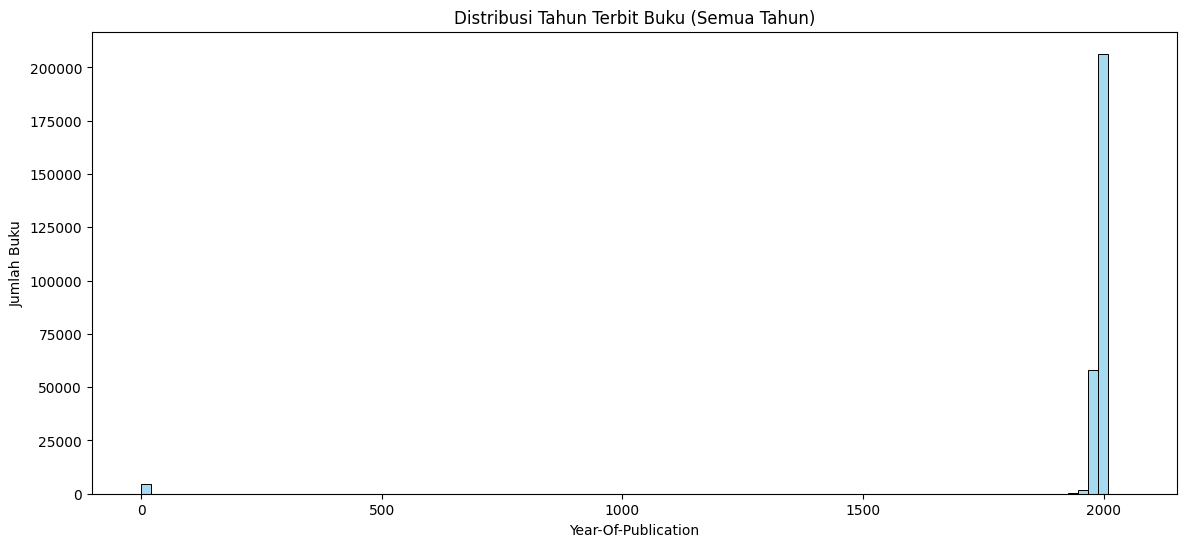

In [ ]:
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

plt.figure(figsize=(14,6))
sns.histplot(books['Year-Of-Publication'].dropna(), bins=100, kde=False, color='skyblue')
plt.title('Distribusi Tahun Terbit Buku (Semua Tahun)')
plt.xlabel('Year-Of-Publication')
plt.ylabel('Jumlah Buku')
plt.show()

Insight: Distribusi tahun terbit buku menunjukkan sebagian besar buku berada pada rentang tahun modern, terutama setelah tahun 1900, dengan lonjakan besar pada tahun-tahun terbaru menjelang tahun 2000-an hingga sekitar 2010-an. Ada juga sejumlah kecil data dengan tahun terbit 0 atau nilai ekstrem, yang mungkin merupakan data tidak valid atau placeholder yang perlu dibersihkan. Pola ini mengindikasikan bahwa koleksi buku dalam dataset lebih banyak memuat karya-karya relatif baru dibandingkan dengan buku-buku klasik atau sangat tua.

##### Visualisasi Publisher dan Penulis Terbanyak

<ipython-input-12-5ea1d01bb721>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis')


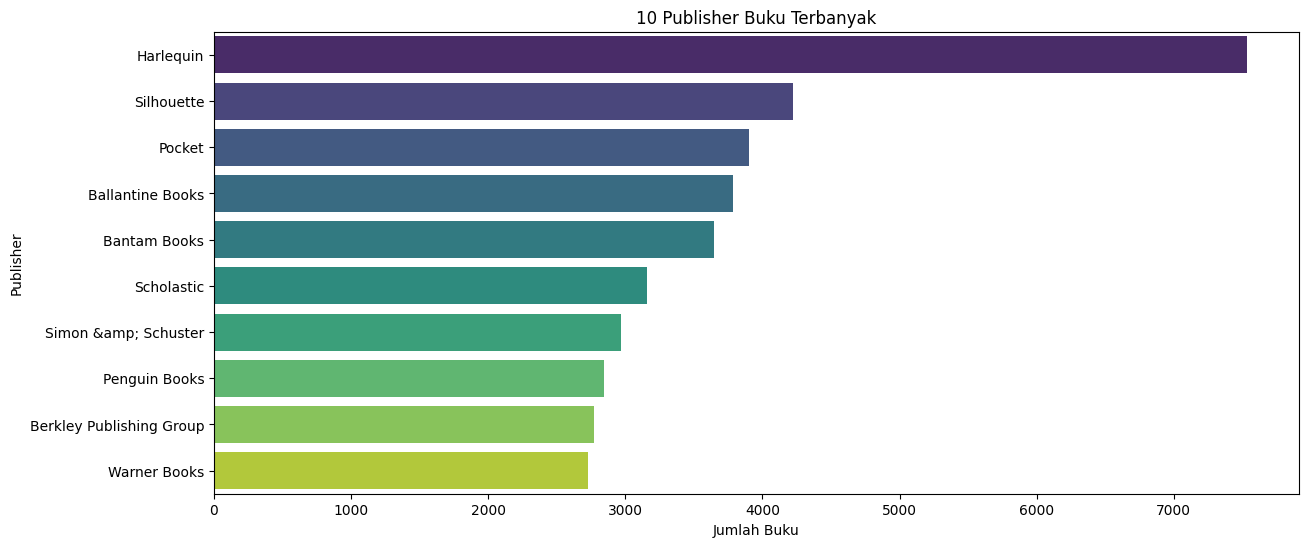

<ipython-input-12-5ea1d01bb721>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette='magma')


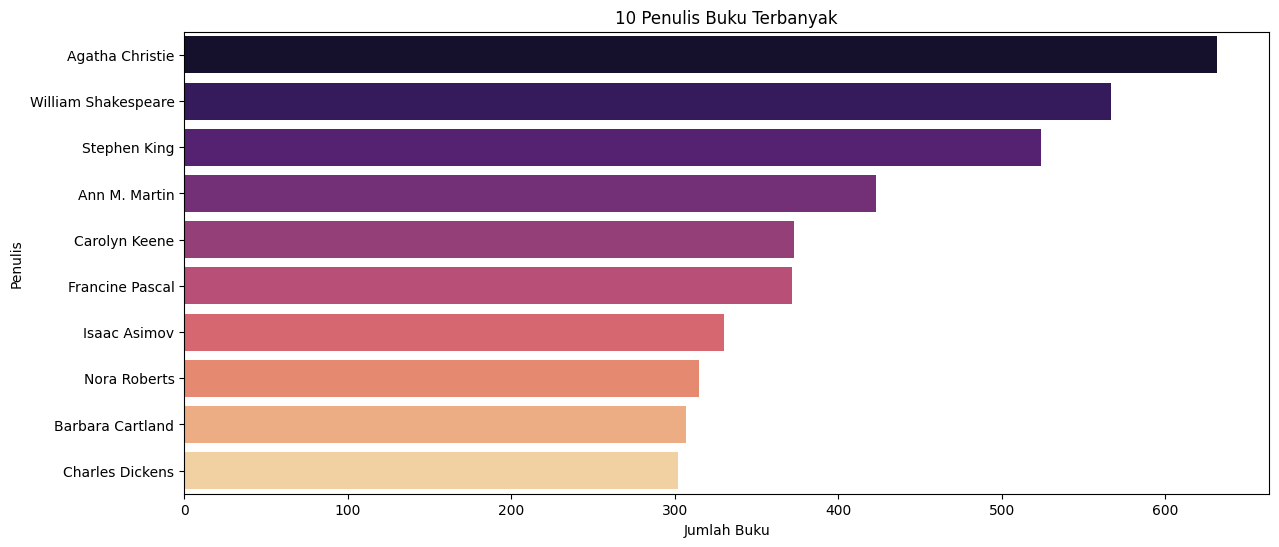

In [ ]:
plt.figure(figsize=(14,6))
top_publishers = books['Publisher'].value_counts().head(10)
sns.barplot(x=top_publishers.values, y=top_publishers.index, palette='viridis')
plt.title('10 Publisher Buku Terbanyak')
plt.xlabel('Jumlah Buku')
plt.ylabel('Publisher')
plt.show()

plt.figure(figsize=(14,6))
top_authors = books['Book-Author'].value_counts().head(10)
sns.barplot(x=top_authors.values, y=top_authors.index, palette='magma')
plt.title('10 Penulis Buku Terbanyak')
plt.xlabel('Jumlah Buku')
plt.ylabel('Penulis')
plt.show()

Insight:

Dari visualisasi publisher dan penulis terbanyak, dapat disimpulkan beberapa hal penting:

Publisher Teratas: Penerbit seperti Harlequin, Silhouette, dan Pocket mendominasi jumlah buku dalam dataset, dengan Harlequin memiliki jumlah buku terbanyak yang mencapai sekitar 7.500 judul. Ini menunjukkan peran besar penerbit besar dalam menyediakan koleksi buku yang luas dan beragam.

Penulis Teratas: Penulis seperti Agatha Christie, William Shakespeare, dan Stephen King merupakan pengarang dengan jumlah karya terbanyak dalam dataset. Agatha Christie menjadi yang paling produktif dengan lebih dari 600 judul buku. Ini menunjukkan bahwa karya-karya dari penulis populer sangat berpengaruh dan sering muncul dalam dataset.

##### Cek Missing Values pada Dataset Books

In [ ]:
print("\nJumlah missing values tiap kolom:")
print(books.isna().sum())


Jumlah missing values tiap kolom:
ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    3
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


Insight: Beberapa kolom dalam dataset buku memiliki nilai yang hilang, meskipun jumlahnya relatif sedikit. Kolom Book-Author dan Publisher masing-masing kehilangan 2 entri, sedangkan Year-Of-Publication dan Image-URL-L kehilangan 3 entri.

#### Ratings Variable

##### Menampilkan ringkasan struktur dataset ratings.

In [ ]:
print("Info dataset Ratings:")
print(ratings.info())

Info dataset Ratings:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB
None


Insight: Dataset ratings terdiri dari sekitar 1,15 juta entri dengan tiga kolom utama: User-ID, ISBN, dan Book-Rating. Semua kolom tidak memiliki nilai kosong, menunjukkan data lengkap untuk setiap interaksi pengguna dengan buku. Kolom User-ID dan Book-Rating bertipe numerik (int64), sedangkan ISBN bertipe objek, mencerminkan kode unik buku.

##### Meampilkan Statistik Data Ratings

In [ ]:
print(f"Jumlah data ratings: {len(ratings)}")
print(f"Jumlah nilai unik rating: {ratings['Book-Rating'].nunique()}")
print("Frekuensi nilai rating (top 10):")
print(ratings['Book-Rating'].value_counts().head(10))

Jumlah data ratings: 1149780
Jumlah nilai unik rating: 11
Frekuensi nilai rating (top 10):
Book-Rating
0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
Name: count, dtype: int64


Insight: Distribusi rating menunjukkan bahwa nilai 0 mendominasi jumlah rating yang diberikan, yaitu sebanyak lebih dari 700 ribu, yang bisa mengindikasikan pengguna yang tidak memberikan penilaian atau interaksi minimal dengan buku. Rating dengan nilai 8 dan 10 juga cukup sering muncul, menunjukkan preferensi positif yang kuat terhadap beberapa buku. Sedangkan rating di bawah 5 memiliki frekuensi yang lebih rendah, menunjukkan bahwa pengguna cenderung memberikan rating tinggi atau tidak memberikan rating (0).

##### Visualisasi Distribusi Rating Buku

<ipython-input-16-a6dd282f471c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book-Rating', data=ratings, palette='coolwarm', order=sorted(ratings['Book-Rating'].unique()))


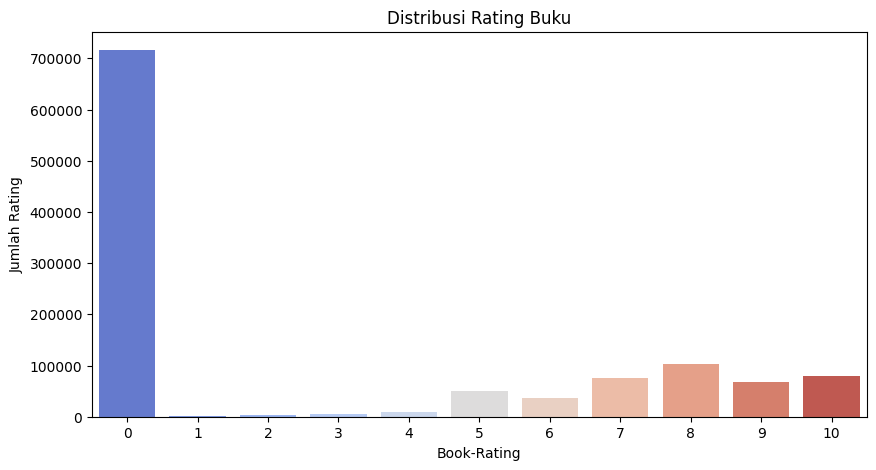

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='Book-Rating', data=ratings, palette='coolwarm', order=sorted(ratings['Book-Rating'].unique()))
plt.title('Distribusi Rating Buku')
plt.xlabel('Book-Rating')
plt.ylabel('Jumlah Rating')
plt.show()

Insight: Distribusi rating buku menunjukkan bahwa sebagian besar interaksi pengguna berupa rating bernilai 0, yang mungkin mengindikasikan ketidaktertarikan atau rating default. Rating dengan nilai 8, 9, dan 10 juga cukup sering diberikan, menandakan bahwa pengguna cenderung memberikan penilaian positif pada buku yang mereka sukai. Rating rendah (1 hingga 4) jarang muncul, menunjukkan bahwa pengguna lebih sering memberikan rating tinggi atau tidak memberikan rating sama sekali.

##### Cek Missing Values pada Dataset Ratings

In [ ]:
print("\nJumlah missing values tiap kolom:")
print(ratings.isna().sum())


Jumlah missing values tiap kolom:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


Insight: Dataset ratings tidak memiliki missing value yang perlu ditangani.

#### Users Variable

##### Menampilkan ringkasan struktur dataset users.

In [ ]:
print("Info dataset Users:")
print(users.info())

Info dataset Users:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB
None


Insight: Dataset pengguna berisi sekitar 278 ribu entri dengan tiga kolom utama: User-ID, Location, dan Age. Kolom User-ID dan Location lengkap tanpa nilai kosong, sementara kolom Age memiliki sekitar 110 ribu nilai yang hilang, menunjukkan kebutuhan penanganan missing value pada usia pengguna.

##### Meampilkan Statistik Data Users

In [ ]:
print(f"Total data users: {len(users)}")

for col in ['User-ID', 'Location']:
    if col in users.columns:
        print(f"\nKolom: {col}")
        print(f"Jumlah nilai unik: {users[col].nunique()}")
        print("5 nilai teratas berdasarkan frekuensi:")
        print(users[col].value_counts().head())

Total data users: 278858

Kolom: User-ID
Jumlah nilai unik: 278858
5 nilai teratas berdasarkan frekuensi:
User-ID
278858    1
1         1
2         1
3         1
4         1
Name: count, dtype: int64

Kolom: Location
Jumlah nilai unik: 57339
5 nilai teratas berdasarkan frekuensi:
Location
london, england, united kingdom       2506
toronto, ontario, canada              2250
sydney, new south wales, australia    1744
melbourne, victoria, australia        1708
portland, oregon, usa                 1629
Name: count, dtype: int64


Insight: Dataset pengguna terdiri dari sekitar 278 ribu entri dengan setiap User-ID unik, menunjukkan bahwa setiap baris mewakili pengguna berbeda tanpa duplikasi. Kolom Location memiliki lebih dari 57 ribu nilai unik, mencerminkan keberagaman geografis yang sangat luas. Lokasi yang paling sering muncul adalah kota-kota besar dan populer seperti London, Toronto, Sydney, Melbourne, dan Portland, yang menunjukkan konsentrasi pengguna utama berada di wilayah perkotaan besar di berbagai negara.

##### Visualisasi Distribusi Users

<ipython-input-20-d16b6a01b508>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.values, y=top_locations.index, palette='crest')


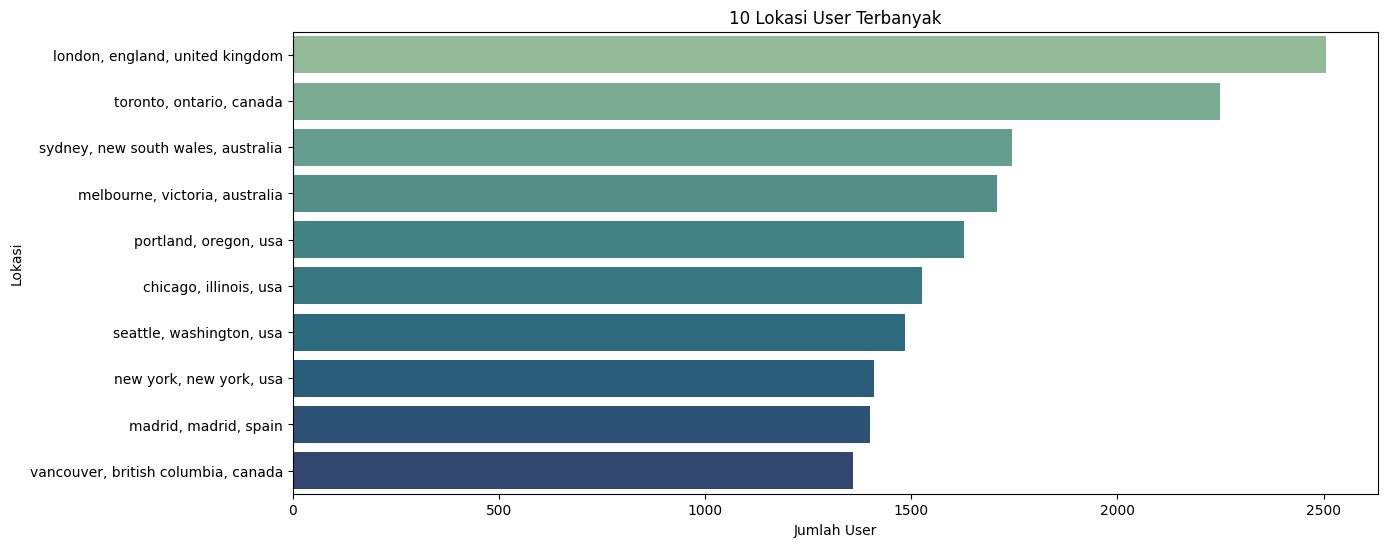

In [ ]:
if 'Location' in users.columns:
    plt.figure(figsize=(14,6))
    top_locations = users['Location'].value_counts().head(10)
    sns.barplot(x=top_locations.values, y=top_locations.index, palette='crest')
    plt.title('10 Lokasi User Terbanyak')
    plt.xlabel('Jumlah User')
    plt.ylabel('Lokasi')
    plt.show()

Insight: Visualisasi menunjukkan bahwa pengguna dalam dataset paling banyak berasal dari kota-kota besar di berbagai negara, dengan London, Inggris sebagai lokasi terbanyak, diikuti oleh Toronto (Kanada), Sydney dan Melbourne (Australia), serta beberapa kota besar di Amerika Serikat seperti Portland, Chicago, Seattle, dan New York. Keberadaan kota-kota besar ini sebagai pusat pengguna menunjukkan konsentrasi tinggi pada wilayah urban dan dapat memberikan gambaran demografis yang penting untuk personalisasi dan segmentasi dalam sistem rekomendasi.

##### Cek Missing Values pada Dataset Users

In [ ]:
print("\nJumlah missing values tiap kolom:")
print(users.isna().sum())


Jumlah missing values tiap kolom:
User-ID          0
Location         0
Age         110762
dtype: int64


Insight: Sebagian besar data kolom Age pada dataset pengguna hilang, dengan sekitar 110 ribu nilai kosong, sedangkan kolom User-ID dan Location lengkap tanpa missing value.

## Data Preparation

### Menangani Missing Values

#### Menangani Missing Values pada Books Variable

##### Mengisi nilai kosong pada kolom `Book-Author` dan `Publisher` dengan label default 'Unknown Author' dan 'Unknown Publisher'

In [ ]:
books['Book-Author'] = books['Book-Author'].fillna('Unknown Author')
books['Publisher'] = books['Publisher'].fillna('Unknown Publisher')

##### Mengisi nilai kosong pada kolom `Year-Of-Publication` dengan nilai median tahun terbit

In [ ]:
median_year = books['Year-Of-Publication'].median()
books['Year-Of-Publication'] = books['Year-Of-Publication'].fillna(median_year).astype(int)

##### Mengisi nilai kosong pada kolom `Image-URL-L` dengan teks 'No Image'

In [ ]:
books['Image-URL-L'] = books['Image-URL-L'].fillna('No Image')

##### Mengecek kembali Missing Value

In [ ]:
print(books.isna().sum())

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64


Insight: Missing Value pada books variable berhasil diatasi.

#### Menangani Missing Values pada Ratings Variable

In [ ]:
print("Missing values di Ratings:")
print(ratings.isna().sum())

Missing values di Ratings:
User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


Insight: Variable Ratings tidak memiliki missing value.

#### Menangani Missing Values pada Users Variable

##### Mengisi nilai kosong pada kolom `Age` dengan nilai median usia pengguna

In [ ]:
median_age = users['Age'].median()
users['Age'] = users['Age'].fillna(median_age).astype(int)

##### Mengecek kembali missing value

In [ ]:
print(users.isna().sum())

User-ID     0
Location    0
Age         0
dtype: int64


Insight: Missing value pada users variable berhasil diatasi

### Memfilter dataset rating untuk hanya mengambil baris dengan nilai `Book-Rating` lebih dari 0

In [ ]:
df = ratings[ratings['Book-Rating'] > 0][['User-ID', 'ISBN', 'Book-Rating']]

### Mendefinisikan skala rating dari 1 sampai 10 dan memuat dataset rating ke format yang sesuai

In [ ]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df, reader)

### Membagi Data Training dan Testing

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## Model Development Collaborative Filtering dengan Algoritma SVD

### Membuat dan Melatih Model SVD

In [ ]:
model = SVD(n_factors=50, n_epochs=30, random_state=42)
model.fit(trainset)

### Membuat Fungsi Rekomendasi Buku untuk User

In [ ]:
def recommend_books_for_user(user_id, model, df, n=10):
    all_books = df['ISBN'].unique()
    books_rated_by_user = df[df['User-ID'] == user_id]['ISBN'].values
    books_to_predict = [book for book in all_books if book not in books_rated_by_user]
    predictions = [model.predict(user_id, book) for book in books_to_predict]
    predictions.sort(key=lambda x: x.est, reverse=True)
    top_preds = predictions[:n]
    recommended_books = []
    for pred in top_preds:
        book_info_df = books[books['ISBN'] == pred.iid]
        if not book_info_df.empty:
            book_info = book_info_df.iloc[0]
            recommended_books.append({
                'ISBN': pred.iid,
                'Book-Title': book_info['Book-Title'],
                'Book-Author': book_info['Book-Author'],
                'Estimated Rating': pred.est
            })
        else:
            pass
    return pd.DataFrame(recommended_books)

### Menguji Sistem Rekomendasi untuk User

In [ ]:
user_id = 276772  # ganti ID dan run untuk mendapat rekomendasi

books_read_by_user = df[df['User-ID'] == user_id].merge(books[['ISBN', 'Book-Title', 'Book-Author']], on='ISBN')

print(f"Books read by User-ID {user_id}:")
if not books_read_by_user.empty:
    display(books_read_by_user[['Book-Title', 'Book-Author', 'Book-Rating']])
else:
    print("This user has not rated any books.")

recommendations = recommend_books_for_user(user_id, model, df, n=10)

print(f"\nRecommended books for User-ID {user_id}:")
if not recommendations.empty:
    display(recommendations)
else:
    print("No recommendations found for this user.")

Books read by User-ID 276772:


,Book-Title,Book-Author,Book-Rating
0,Pay Dirt (Mrs. Murphy Mysteries (Paperback)),RITA MAE BROWN,7
1,Adressat unbekannt.,Kathrine Kressmann Taylor,10
2,Henry der Held.,Roddy Doyle,10



Recommended books for User-ID 276772:


,ISBN,Book-Title,Book-Author,Estimated Rating
0,0811824829,52 Deck Series: 52 Ways to Celebrate Friendship,Lynn Gordon,9.766852
1,0743454529,"My Sister's Keeper : A Novel (Picoult, Jodi)",Jodi Picoult,9.746502
2,0385504209,The Da Vinci Code,Dan Brown,9.721862
3,0441172717,Dune (Remembering Tomorrow),Frank Herbert,9.667607
4,0439136369,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,9.656759
5,0836213319,Dilbert: A Book of Postcards,Scott Adams,9.652009
6,1880418568,"Wolves of the Calla (The Dark Tower, Book 5)",Stephen King,9.600803
7,0316779059,The Baby Book: Everything You Need to Know Abo...,Martha Sears,9.549683


Insight: Pengguna dengan User-ID 276772 telah memberikan rating pada tiga buku dengan skor tinggi, menunjukkan preferensi yang kuat terhadap genre atau penulis tertentu. Rekomendasi yang dihasilkan oleh model SVD menyajikan daftar buku dengan prediksi rating tinggi, yang meliputi karya populer dan penulis terkenal seperti J.K. Rowling, Dan Brown, J.R.R. Tolkien, dan Stephen King. Hal ini menunjukkan bahwa model berhasil menangkap preferensi pengguna dan menyarankan buku yang relevan dan berkualitas tinggi sesuai minat mereka.

## Evaluasi Model dengan RMSE

In [ ]:
predictions = model.test(testset)
rmse = accuracy.rmse(predictions)

RMSE: 1.6401


Insight: Hasil evaluasi model dengan RMSE sebesar 1.6401 menunjukkan bahwa model memiliki tingkat kesalahan yang tergolong moderat dan dapat diterima mengingat kompleksitas dan karakteristik dataset yang sangat beragam. Preferensi pengguna yang beragam dan distribusi rating yang tidak merata, termasuk banyaknya rating nol, menyulitkan model dalam memprediksi dengan presisi tinggi. Selain itu, model hanya mengandalkan data rating tanpa fitur pendukung seperti genre atau demografi pengguna, sehingga keterbatasan informasi ini juga memengaruhi akurasi prediksi. Kebisingan dan inkonsistensi dalam dataset yang besar turut menjadi faktor yang menyumbang tingginya nilai error